# Bitcoin DCA strategies comparison

Dollar Cost Averaging (DCA) is a continuous buying strategy that has the purpose of channeling bitcoin's volatility towards the buyer's advantage. Because of the high volatility, timing the market is extremely difficult, and hence instead of trying to find it, this strategy brings peace of mind through frequent purchases and simply holding it forever to accumulate the gains from Number-go-up technology. 
However, little is available in the internet to evaluate what is the best frequency to buy, and whether there is any active tricks to be done on top of the passive DCA. In this article I try to address these questions:

1. is there any dca frequency which outperforms the others?
2. is there anything else that can be done on top of the dca?

1 Compare one offs with monthly DCA for a total of 10k usd bought over the period
Choose specific start dates and apply it from them. Some at lows, some at highs

2 Compare 1-90 day DCA freq (plot daily, weekly monthly, quarterly)
Set monthly contrib to 1k usd
For each DCA frequency, calculate accum btcs till today, from each start date. Score is simple sum of the array. Check the differences in the scores

Check the relation of the optimal frequency with the volatility

3. compare the winning DCA strategy with active strategies that try to identify distortions and benefit from it:
A) different mixes of DCA and cash to make buys at dips (e.g big unrealized ratio; 200d moving average, etc)
B)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
os.getcwd()

'C:\\Users\\mrchi\\OneDrive\\Documents\\GitHub\\btc-dca'

In [2]:
def executeDCA(data, start_date, purchase_freq_days, buy_contr, max_contrib):
    
    #dca_active mask tells the period in which the strategy is being executed
    data['dca_active'] = data['Time'] >= start_date

    #dca_days - how many days the strategy is being executed   
    data['dca_days'] = False
    mask = (data['dca_active'] == True)
    data['dca_days'].loc[mask] = range(1,mask.sum()+1)   

    # a trigger indicating buy moments
    data['dca_buy_trigger'] = data['dca_active'] & (data['dca_days'] % purchase_freq_days == 1)

    # calculate accums    
    data['purchase_usd'] = buy_contr * data['dca_buy_trigger']
    data['accum_invested_usd'] = data['purchase_usd'].cumsum()
    data['purchase_usd'][data['accum_invested_usd'] > max_contrib] = 0.0 # correction for not exceeding max_contrib
    data['accum_invested_usd'][data['accum_invested_usd'] > max_contrib] = max_contrib # correction for not exceeding max_contrib    
    data['purchase_btc'] = data['purchase_usd'] / data['price_usd'] * data['dca_buy_trigger']      
    data['accum_btc'] = data['purchase_btc'].cumsum()
        
    
    
    data['portfolio_value_usd'] = data['accum_btc'] * data['price_usd']  
    data['gains_perc'] = data['portfolio_value_usd'] / data['accum_invested_usd'] * 100
    
    out_metrics = {}
    out_metrics['start_date'] = start_date
    out_metrics['total_days'] = int(data.dca_days.tail(1)) #- start_date) #TODO fix this bug, dca days is not correct
    out_metrics['total_invested_usd'] = float(data.accum_invested_usd.tail(1))
    out_metrics['net_worth'] = float(data.portfolio_value_usd.tail(1))
    out_metrics['gains_perc'] = float(data.gains_perc.tail(1))
    out_metrics['accum_btc'] = float(data.accum_btc.tail(1))
    #out_metrics = pd.DataFrame(out_metrics)
    
    
    return out_metrics


In [3]:
def plotGains(strategies, total_days):
    
    
    fig, (ax1, ax2) = plt.subplots(2,figsize=(20,15))
    
    df1 = pd.DataFrame()
    df1['price_usd'] = strategies.price_usd
    df1['accum_invested_usd'] = strategies.accum_invested_usd
    df1['portfolio_value_usd'] = strategies.portfolio_value_usd
    df1 = df1.set_index(strategies.Time)
    ax1.plot(df1.tail(total_days))
    ax1.set_title('Values')
    ax1.set(ylabel='USD')

    df2 = pd.DataFrame()
    df2['gains_perc'] = strategies.gains_perc
    df2 = df2.set_index(strategies.Time)
    ax2.plot(df2.tail(total_days))
    ax2.set_title('Gains')
    ax2.set(ylabel='Percentage (%)')

    plt.gcf().autofmt_xdate()    
    plt.show()

In [4]:
data = pd.DataFrame(pd.read_csv("btcdata.csv", sep='\t'))
data = data[0:3700]
data.columns

Index(['Time', 'BTC / USD Denominated Closing Price',
       'BTC / MVRV (Market Cap / Realized Market Cap)',
       'BTC / 30 Day Volatility', 'BTC / 180 Day Volatility'],
      dtype='object')

In [5]:
data.Time = pd.to_datetime(data.Time)
data.rename(columns={'BTC / USD Denominated Closing Price': 'price_usd'}, inplace=True)
data.rename(columns={'BTC / MVRV (Market Cap / Realized Market Cap)': 'ratio_mktcap_realizedmktcap'}, inplace=True)
data.rename(columns={'BTC / 30 Day Volatility': '30_day_volatility'}, inplace=True)
data.rename(columns={'BTC / 180 Day Volatility': '180_day_volatility'}, inplace=True)
data.columns

Index(['Time', 'price_usd', 'ratio_mktcap_realizedmktcap', '30_day_volatility',
       '180_day_volatility'],
      dtype='object')

The chart below shows bitcoin price in USD since its inception, in log scale.

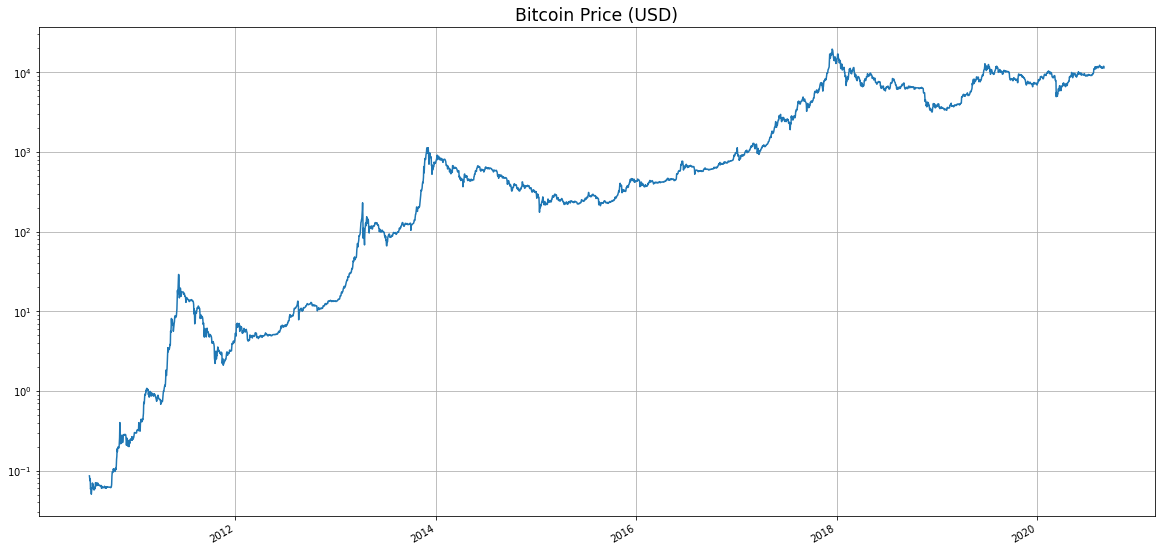

In [6]:
# plot btc usd price
fig = plt.figure(figsize=(20, 10))
df = pd.DataFrame()
df['value'] = data.price_usd
df = df.set_index(data.Time)
plt.plot(df)
plt.gcf().autofmt_xdate()
plt.title('Bitcoin Price (USD)', fontsize='xx-large')
plt.yscale('log')
plt.grid()

An here you can see the volatility:

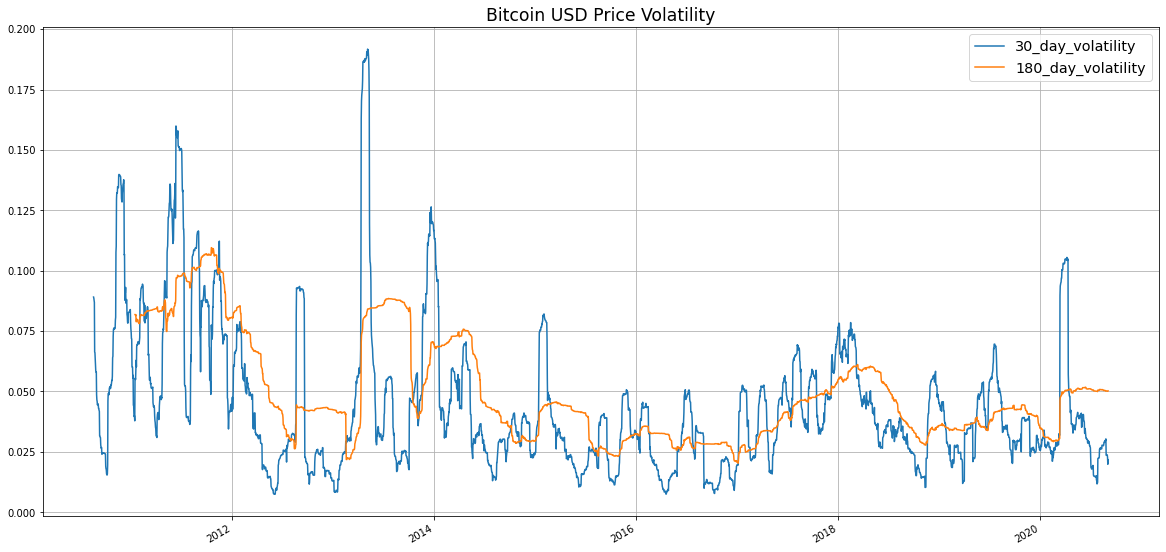

In [7]:
# plot btc usd price
fig = plt.figure(figsize=(20, 10))
df = pd.DataFrame()
df['30_day_volatility'] = data['30_day_volatility']
df['180_day_volatility'] = data['180_day_volatility']
df = df.set_index(data.Time)
plt.plot(df, label = df.columns)
plt.gcf().autofmt_xdate()
plt.legend(fontsize='x-large')
plt.title('Bitcoin USD Price Volatility', fontsize='xx-large')
plt.grid()

In [8]:
def plotStrategies(one_off_strategies, simple_dca_strategies={}):
    fig1,ax = plt.subplots()
    num_data_points_plot = 1600

    # Plot BTC price in primary axis
    df = pd.DataFrame()
    df['btc_price'] = data.price_usd
    df = df.set_index(data.Time)
    ax.plot(df.tail(num_data_points_plot),'k', label='btc_price_usd')
    plt.legend(loc='best')
    ax.set_ylabel("BTC Price (USD)",fontsize=10)

    # Plot strategies (BTC accumulated) in secondary axis
    num_strategies = len(one_off_strategies['start_date'])
    df = pd.DataFrame()
    ax2 = ax.twinx()
    date_str = []
    for i in range(num_strategies):
        date_str.append('One-off in '+ str(one_off_strategies['out_metrics']['start_date'][i]).split(' ')[0])
        df[date_str[i]] = one_off_strategies['data'][i]['accum_btc']
    df = df.set_index(data.Time)
    ax2.plot(df.tail(num_data_points_plot), label=date_str)
    plt.legend(loc='center left')

    ax2.set_ylabel("Accumulated BTCs",fontsize=10)
    ax2.set_ylim([0,10])

    plt.gcf().autofmt_xdate()
    plt.gcf().set_size_inches(15, 10)
    plt.grid()
    plt.show()
    
    
    # Plot DCA strategies    
    if simple_dca_strategies != {}:
        num_strategies = len(simple_dca_strategies['start_date'])
        df = pd.DataFrame()
        #ax3 = ax.twinx()
        date_str = []
        for i in range(num_strategies):
            date_str.append('Monthly DCA starting '+ str(simple_dca_strategies['out_metrics']['start_date'][i]).split(' ')[0])
            df[date_str[i]] = simple_dca_strategies['data'][i]['accum_btc']
        df = df.set_index(data.Time)
        ax2.plot(df.tail(num_data_points_plot), label=date_str)
        plt.legend(loc='center left')
        plt.show()


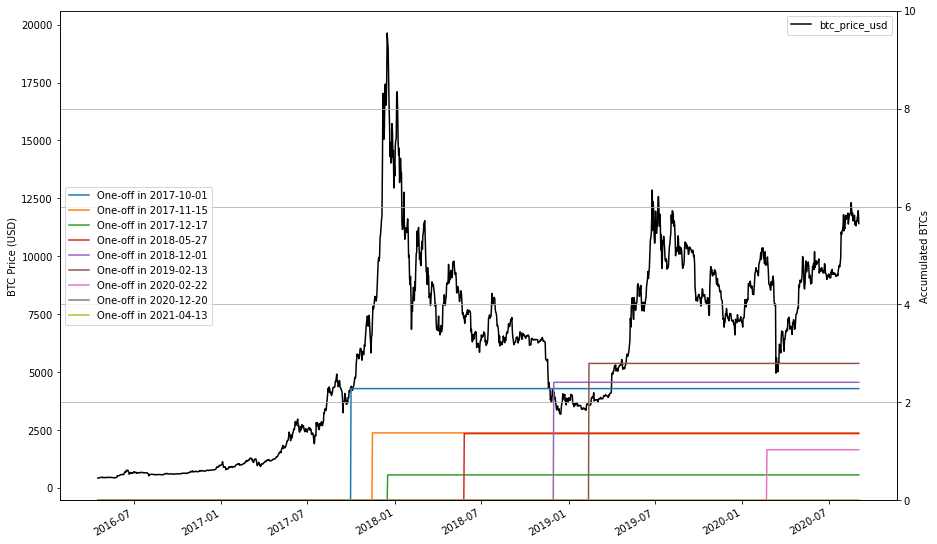

In [9]:
# Strategy: one-off buys 

total_contrib_usd = 10000

# Define the strategies parameters
one_off_strategies = {}
one_off_strategies['start_date'] = pd.to_datetime(['2017/10/01', '2017/11/15', '2017/12/17', '2018/5/27', '2018/12/1', '2019/02/13', '2020/02/22', '2020/12/20', '2021/04/13'])
num_strategies = len(one_off_strategies['start_date'])
one_off_strategies['purchase_freq_days'] = [999999] * num_strategies
one_off_strategies['buy_contr_usd'] = [total_contrib_usd] * num_strategies
one_off_strategies['data'] = [data] * num_strategies
one_off_strategies['out_metrics'] = {}

# Execute the strategy
for i in range(num_strategies):  
    one_off_strategies['data'][i] = data.copy()
    one_off_strategies['out_metrics'][i] = executeDCA(one_off_strategies['data'][i], 
                                                      one_off_strategies['start_date'][i], 
                                                      one_off_strategies['purchase_freq_days'][i], 
                                                      one_off_strategies['buy_contr_usd'][i],
                                                     total_contrib_usd)
one_off_strategies['out_metrics'] = (pd.DataFrame(one_off_strategies['out_metrics'])).T

plotStrategies(one_off_strategies)

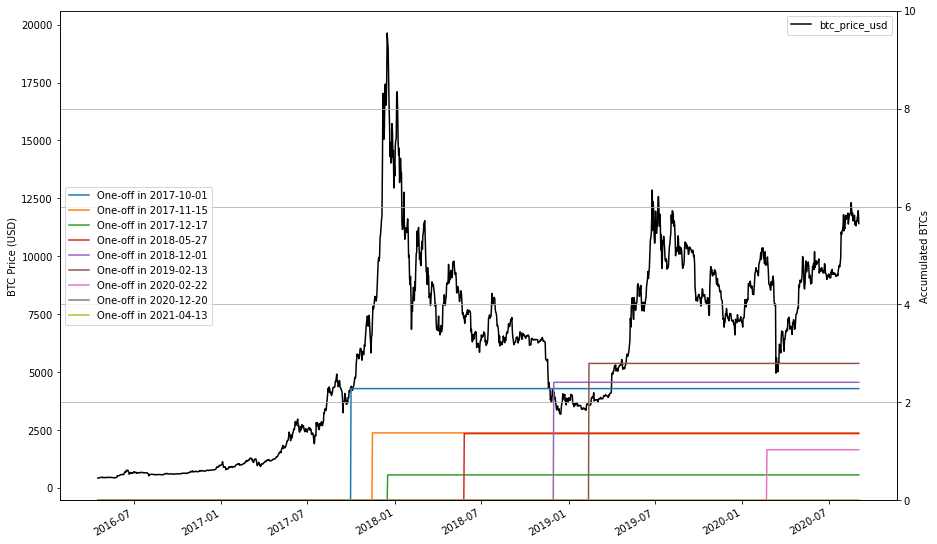

No handles with labels found to put in legend.


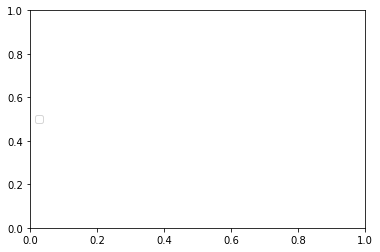

In [10]:
# Strategy: monthly DCA 

total_contrib_usd = 10000
purchase_freq_days = 60

# Define the strategies parameters
simple_dca_strategies = {}
simple_dca_strategies['start_date'] = one_off_strategies['start_date']
num_strategies = len(simple_dca_strategies['start_date'])
len_strategies_days = (pd.to_datetime(list(data.Time.tail(1)) * num_strategies) - simple_dca_strategies['start_date']).days.values + 1
simple_dca_strategies['purchase_freq_days'] = [purchase_freq_days] * num_strategies
simple_dca_strategies['buy_contr_usd'] = total_contrib_usd / len_strategies_days * simple_dca_strategies['purchase_freq_days']
simple_dca_strategies['data'] = [data] * num_strategies
simple_dca_strategies['out_metrics'] = {}

# Execute the strategy
for i in range(num_strategies):  
    simple_dca_strategies['data'][i] = data.copy()
    simple_dca_strategies['out_metrics'][i] = executeDCA(simple_dca_strategies['data'][i], 
                                                         simple_dca_strategies['start_date'][i], 
                                                         simple_dca_strategies['purchase_freq_days'][i], 
                                                         simple_dca_strategies['buy_contr_usd'][i],
                                                        total_contrib_usd)
simple_dca_strategies['out_metrics'] = (pd.DataFrame(simple_dca_strategies['out_metrics'])).T

monthly_dca = simple_dca_strategies.copy()

plotStrategies(one_off_strategies, monthly_dca)

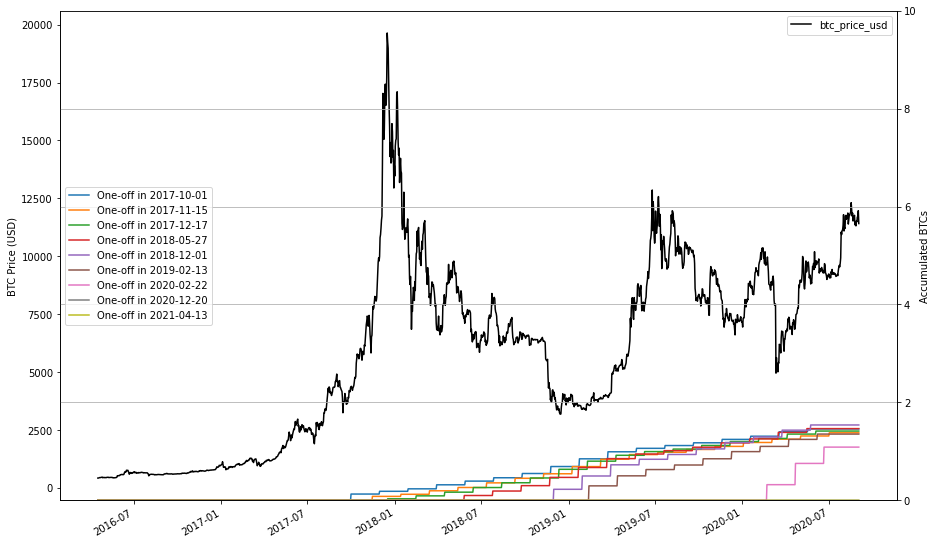

No handles with labels found to put in legend.


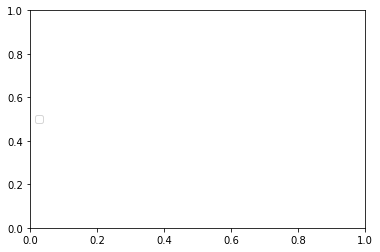

In [11]:
# Strategy: monthly DCA 

purchase_freq_days = 7

simple_dca_strategies['purchase_freq_days'] = [purchase_freq_days] * num_strategies
simple_dca_strategies['buy_contr_usd'] = total_contrib_usd / len_strategies_days * simple_dca_strategies['purchase_freq_days']
simple_dca_strategies['data'] = [data] * num_strategies
simple_dca_strategies['out_metrics'] = {}

# Execute the strategy
for i in range(num_strategies):  
    simple_dca_strategies['data'][i] = data.copy()
    simple_dca_strategies['out_metrics'][i] = executeDCA(simple_dca_strategies['data'][i], 
                                                         simple_dca_strategies['start_date'][i], 
                                                         simple_dca_strategies['purchase_freq_days'][i], 
                                                         simple_dca_strategies['buy_contr_usd'][i],
                                                        np.inf)
simple_dca_strategies['out_metrics'] = (pd.DataFrame(simple_dca_strategies['out_metrics'])).T

weekly_dca = simple_dca_strategies.copy()

plotStrategies(monthly_dca, weekly_dca)

In [12]:
def plot_oneoff_vs_DCA(strategy_01, strategy_02, strategy_03, strategy_04):

    fig1,ax = plt.subplots()
    num_data_points_plot = 10 + int((data.Time.tail(1) - strategy_01['start_date']).dt.days)

    # Plot BTC price in primary axis
    df = pd.DataFrame()
    df['btc_price'] = data.price_usd
    df = df.set_index(data.Time)
    ax.plot(df.tail(num_data_points_plot),'k', label='btc_price_usd')    
    plt.legend()
    ax.set_ylabel("BTC Price (USD)",fontsize=10)

    # Plot strategies (BTC accumulated) in secondary axis
    date_str = []
    df = pd.DataFrame()
    ax2 = ax.twinx()
    date_str.append(strategy_01['label'])
    df[date_str[-1]] = strategy_01['data']['accum_btc']
    
    date_str.append(strategy_02['label'])
    df[date_str[-1]] = strategy_02['data']['accum_btc']
    
    date_str.append(strategy_03['label'])
    df[date_str[-1]] = strategy_03['data']['accum_btc']
    
    date_str.append(strategy_04['label'])
    df[date_str[-1]] = strategy_04['data']['accum_btc']
    
    
    df = df.set_index(data.Time)
    ax2.plot(df.tail(num_data_points_plot), label=date_str)    


    
    ax2.set_ylabel("Accumulated BTCs",fontsize=10)
#     ax2.set_ylim([0,3])
    plt.gcf().autofmt_xdate()
    plt.gcf().set_size_inches(15, 10)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

Through the chart below, we can compare the results (in terms of accumulated BTC over time) of applying different DCA frequencies, also in comparison with a one-off purchase in the begining of the period. 
All the lines consider a 10k USD overall contribution, spread over the investment period and the according to the number of contributions, depending on the frequency.
I have purposefully trunkated the date to start only after end 2017, not to bother so much with very old data.

In [13]:
one_off_strategies = {}
montly_dca = {}  
weekly_dca = {}  
daily_dca = {}  
start_day_init = 2600

def visualize_dca(start_day=start_day_init):
    
    #### Strategy: one-off buys 
    start_date = data.Time[start_day]
    total_days = int((data.Time.tail(1) - start_date).dt.days)

    total_contrib_usd = 10000

    # Define the strategies parameters
    one_off_strategies['start_date'] = start_date
    one_off_strategies['purchase_freq_days'] = 999999
    one_off_strategies['buy_contr_usd'] = total_contrib_usd
    one_off_strategies['data'] = data.copy()    
    one_off_strategies['out_metrics'] = {}
    one_off_strategies['label'] = 'One-off in '+ str(start_date).split(' ')[0]

    # Execute the strategy
    one_off_strategies['out_metrics'] = executeDCA(one_off_strategies['data'], 
                                                   one_off_strategies['start_date'], 
                                                   one_off_strategies['purchase_freq_days'], 
                                                   one_off_strategies['buy_contr_usd'],
                                                  total_contrib_usd)


    #### Strategy: DCA
    total_contrib_usd = 10000
    
    ### Monthly
    purchase_freq_days = 30    
    monthly_dca['start_date'] = start_date
    monthly_dca['purchase_freq_days'] = purchase_freq_days
    monthly_dca['buy_contr_usd'] = total_contrib_usd / (total_days + 1) * monthly_dca['purchase_freq_days']
    monthly_dca['data'] = data.copy()
    monthly_dca['out_metrics'] = {}
    monthly_dca['label'] = 'Monthly DCA'

    monthly_dca['out_metrics'] = executeDCA(monthly_dca['data'], 
                                          monthly_dca['start_date'], 
                                          monthly_dca['purchase_freq_days'], 
                                          monthly_dca['buy_contr_usd'],
                                           total_contrib_usd)
    
    ### Weekly
    purchase_freq_days = 7    
    weekly_dca['start_date'] = start_date
    weekly_dca['purchase_freq_days'] = purchase_freq_days
    weekly_dca['buy_contr_usd'] = total_contrib_usd / (total_days + 1) * weekly_dca['purchase_freq_days']
    weekly_dca['data'] = data.copy()
    weekly_dca['out_metrics'] = {}
    weekly_dca['label'] = 'Weekly DCA'

    weekly_dca['out_metrics'] = executeDCA(weekly_dca['data'], 
                                          weekly_dca['start_date'], 
                                          weekly_dca['purchase_freq_days'], 
                                          weekly_dca['buy_contr_usd'],
                                          total_contrib_usd)
    
    ### Daily
    purchase_freq_days = 2    
    daily_dca['start_date'] = start_date
    daily_dca['purchase_freq_days'] = purchase_freq_days
    daily_dca['buy_contr_usd'] = total_contrib_usd / (total_days + 1) * daily_dca['purchase_freq_days']
    daily_dca['data'] = data.copy()
    daily_dca['out_metrics'] = {}
    daily_dca['label'] = 'Daily DCA'

    daily_dca['out_metrics'] = executeDCA(daily_dca['data'], 
                                          daily_dca['start_date'], 
                                          daily_dca['purchase_freq_days'], 
                                          daily_dca['buy_contr_usd'],
                                         total_contrib_usd)
    
    
    
    plot_oneoff_vs_DCA(one_off_strategies, monthly_dca, weekly_dca, daily_dca)


slider_widget = widgets.IntSlider(
    value=start_day_init,
    min=start_day_init,
    max=len(data.Time) - 1,
    layout=widgets.Layout(width='100%')
)    
interactive_plot = interactive(visualize_dca, start_day=slider_widget)
interactive_plot

interactive(children=(IntSlider(value=2600, description='start_day', layout=Layout(width='100%'), max=3699, mi…

We can see a few things:
1. One-off contributions can give you a good advantage (e.g. up to 3x), but it requires a very precise timing of the market. If losing that timing, one can be in a real disadvantage in comparison to DCA. For example, if bought on 01/oct/2017, you would have bought roughly 2.25 BTCs, against 1.25 with DCA strategies. However, if you lost this timing by a month, and instead bought 01/11/2017, this difference drops to only 1.5 vs 1.22. If you had bought even 1 month later, 15/dec/2017, close to the top of the market, the figure would be the oppositem with DCA accumulating 1.21 against less than 0.6 for the one-off. That is, in this window of 2 months, the loss wrt max possible return of the DCA was only ~3%, while the one-off it was ~75%!!

Conclusion --> DCA is much superior to one-off strategies.

2. There seems to be some relative benefits for more more spaced buying times, instead of buying too frequently. 

Lets investigate that.

Before finding the best optimal DCA frequency, lets first try to see if we can identify something with the slider:

In [14]:
quarterly_dca = {}
montly_dca = {}  
weekly_dca = {}  
daily_dca = {}  
start_day_init = 2600

def visualize_dca(start_day=start_day_init):
    
    #### Strategy: one-off buys 
    start_date = data.Time[start_day]
    total_days = int((data.Time.tail(1) - start_date).dt.days)

    total_contrib_usd = 10000

    # Define the strategies parameters
    quarterly_dca['start_date'] = start_date
    quarterly_dca['purchase_freq_days'] = 90
    quarterly_dca['buy_contr_usd'] = total_contrib_usd / (total_days + 1) * quarterly_dca['purchase_freq_days']
    quarterly_dca['data'] = data.copy()    
    quarterly_dca['out_metrics'] = {}
    quarterly_dca['label'] = 'Quarterly DCA'

    # Execute the strategy
    quarterly_dca['out_metrics'] = executeDCA(quarterly_dca['data'], 
                                               quarterly_dca['start_date'], 
                                               quarterly_dca['purchase_freq_days'], 
                                               quarterly_dca['buy_contr_usd'],
                                             total_contrib_usd)


    
    ### Monthly
    purchase_freq_days = 30    
    monthly_dca['start_date'] = start_date
    monthly_dca['purchase_freq_days'] = purchase_freq_days
    monthly_dca['buy_contr_usd'] = total_contrib_usd / (total_days + 1) * monthly_dca['purchase_freq_days']
    monthly_dca['data'] = data.copy()
    monthly_dca['out_metrics'] = {}
    monthly_dca['label'] = 'Monthly DCA'

    monthly_dca['out_metrics'] = executeDCA(monthly_dca['data'], 
                                          monthly_dca['start_date'], 
                                          monthly_dca['purchase_freq_days'], 
                                          monthly_dca['buy_contr_usd'],
                                           total_contrib_usd)
    
    ### Weekly
    purchase_freq_days = 7    
    weekly_dca['start_date'] = start_date
    weekly_dca['purchase_freq_days'] = purchase_freq_days
    weekly_dca['buy_contr_usd'] = total_contrib_usd / (total_days + 1) * weekly_dca['purchase_freq_days']
    weekly_dca['data'] = data.copy()
    weekly_dca['out_metrics'] = {}
    weekly_dca['label'] = 'Weekly DCA'

    weekly_dca['out_metrics'] = executeDCA(weekly_dca['data'], 
                                          weekly_dca['start_date'], 
                                          weekly_dca['purchase_freq_days'], 
                                          weekly_dca['buy_contr_usd'],
                                          total_contrib_usd)
    
    ### Daily
    purchase_freq_days = 2    
    daily_dca['start_date'] = start_date
    daily_dca['purchase_freq_days'] = purchase_freq_days
    daily_dca['buy_contr_usd'] = total_contrib_usd / (total_days + 1) * daily_dca['purchase_freq_days']
    daily_dca['data'] = data.copy()
    daily_dca['out_metrics'] = {}
    daily_dca['label'] = 'Daily DCA'

    daily_dca['out_metrics'] = executeDCA(daily_dca['data'], 
                                          daily_dca['start_date'], 
                                          daily_dca['purchase_freq_days'], 
                                          daily_dca['buy_contr_usd'],
                                         total_contrib_usd)
    
    
    
    plot_oneoff_vs_DCA(quarterly_dca, monthly_dca, weekly_dca, daily_dca)


slider_widget = widgets.IntSlider(
    value=start_day_init,
    min=start_day_init,
    max=len(data.Time) - 1,
    layout=widgets.Layout(width='100%')
)    
interactive_plot = interactive(visualize_dca, start_day=slider_widget)
interactive_plot

interactive(children=(IntSlider(value=2600, description='start_day', layout=Layout(width='100%'), max=3699, mi…

Interestingly, it seems visually that the lower frequencies outperform the higher ones. So lets define a metric for evaluating it more objectively.
For each frequency, i'll calculate BTC qty as a function of start date. I'll create a score metric that gets the average BTC per day

for each freq
    for each start day
        calc BTCs
        avg btc/day = BTCs / num_days
    DCA freq score = DCA freq score + acg btc/day

In [15]:
# Comparison of DCA strategies 
# 2 Compare 1-90 day DCA freq (plot daily, weekly monthly, quarterly)
# Set monthly contrib to 1k usd
# For each DCA frequency, calculate accum btcs till today, from each start date. Score is simple sum of the array. Check the differences in the scores



num_days = 10#365*2
# num_days = len(data.Time)

DCA_res_all_freq = {}
DCA_res_all_freq['single_freq_res_list'] = []
DCA_res_all_freq['metrics'] = {}
DCA_res_all_freq['metrics']['avg_accum_btc_per_month'] = []#[0.0] * num_days

# Execute the strategy
start = time.time()

# loop through frequencies
freqs_to_test_days = [90, 60, 30, 7, 2]

for j, freq in enumerate(freqs_to_test_days):
    single_freq_res = {}
    single_freq_res['data'] = [data] * num_days
    single_freq_res['purchase_freq_days'] = [freq] * num_days
    single_freq_res['buy_contr_usd'] = np.array(single_freq_res['purchase_freq_days']) * 1000 / 30 
    single_freq_res['out_metrics'] = {}

    # Loop through start dates
    print(freq)
    for i in range(0, num_days):  
        single_freq_res['data'][i] = data.copy()
        single_freq_res['out_metrics'][i] = executeDCA(single_freq_res['data'][i], 
                                                             data.Time.iat[-1-i], 
                                                             single_freq_res['purchase_freq_days'][i], 
                                                             single_freq_res['buy_contr_usd'][i])
    single_freq_res['out_metrics'] = (pd.DataFrame(single_freq_res['out_metrics'])).T
    
    DCA_res_all_freq['single_freq_res_list'].append(single_freq_res.copy())
    DCA_res_all_freq['metrics']['avg_accum_btc_per_month'].append(single_freq_res['out_metrics']['accum_btc'].sum() / num_days * 30)
    
end = time.time()

print('elapsed time = %f' % (end - start))

DCA_res_all_freq['metrics']['avg_accum_btc_per_month']


# which metric to use??

90


TypeError: executeDCA() missing 1 required positional argument: 'max_contrib'

In [ ]:
freq = 30
start_date = data.Time.iat[-365]
buy_contr = 1000 * freq / 30

test_data = data.copy()
metrics = executeDCA(test_data,
                     start_date, 
                     freq, 
                     buy_contr)
metrics

In [ ]:
freqs_to_test_days = [90, 60, 30, 7, 2]
num_days = 5
accum_btc = np.empty((len(freqs_to_test_days),num_days))

for j, freq in enumerate(freqs_to_test_days):
    for i in range(0, num_days):  
        test_data = data.copy()
        metrics = executeDCA(test_data,
                                  data.Time.iat[-i], 
                                  freq, 
                                  buy_contr)
        accum_btc[j][i] = metrics['accum_btc']

accum_btc